# Prob of Emergence for Mask Model


$P(\text{Node wears mask}) = m$


$E_{L, 0}$ := Following an edge, the probability of extinction at level $L$ given the node wears a mask


$E_{L, 1}$ := Following an edge, the probability of extinction at level $L$ given the node doesn't wear a mask



## 1. Condition on num of neighbors


$B_k$ := Node v has $k - 1$ lower level neighbors

$P(E_{L, i}) = \sum_{k = 0}^{\infty}{P(E_{L, i} | B_k) * P(B_k)}$


$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$



## 2. Condition on num of neighbors wearing a mask

$N$ := Num of neighbors wearing masks 
 
$N \sim \operatorname{Binomial}\left(k - 1, m\right)$


$ P(E_{L, i} | B_k) = \sum_{n = 0}^{k - 1} P(E_{L, i} | B_k, N = n) * \left(\begin{array}{c}
k - 1 \\
n
\end{array}\right) * m^{n} * (1 - m)^{k - 1 - n} $



## 3. Condition on num of infections

$I_0$ := $I_0$ of $n$ lower level neighbors who wear masks are active

$I_1$ := $I_1$ of $k-1-n$ lower level neighbors who don't wear masks are active



### Inital infective wears a mask

$I_0 \sim \operatorname{Binomial}\left(n, T_2)\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, T_1)\right)$


$P(E_{L, 0} | B_k, N = n) $

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}P(E_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_2 ^{k_0} * (1 - T_2)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_1 ^{k_1} * (1 - T_1)^{k - 1 - n - k_1}$

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}\left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_2 ^{k_0} * (1 - T_2)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_1 ^{k_1} * (1 - T_1)^{k - 1 - n - k_1} * P(E_{L,0})^{k_0} * P(E_{L, 1})^{k_1}$
 
--- 

### Inital infective doesn't wear a mask

$I_0 \sim \operatorname{Binomial}\left(n, T_4)\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, T_3)\right)$


$P(E_{L, 1} | B_k, N = n) $

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}P(E_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_4 ^{k_0} * (1 - T_4)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_3 ^{k_1} * (1 - T_3)^{k - 1 - n - k_1}$

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}\left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_4 ^{k_0} * (1 - T_4)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_3 ^{k_1} * (1 - T_3)^{k - 1 - n - k_1} * P(E_{L,0})^{k_0} * P(E_{L, 1})^{k_1}$

In [10]:
from __future__ import division
import argparse
import math
import sys

import numpy as np
from scipy.optimize import fsolve
from scipy.special import comb
from scipy.stats import poisson
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.misc
from scipy import linalg as LA

def PE(i, is_intermediate, E0, E1, T_list, m, mean_degree):
    res = 0
    for k in range(0, max_degree):
        prob_r = poisson.pmf(k, mean_degree)
        
        if is_intermediate: # intermediate q using excess degree distribution
            pb = prob_r * k * 1.0 / mean_degree 
        else:
            pb = prob_r
            
        res += pb * PE_B(i, is_intermediate, k, E0, E1, T_list, m)
    return res

def PE_B(i, is_intermediate, k, E0, E1, T_list, m):
    res = 0
    one_minus_m = 1 - m
    
    if is_intermediate: # intermediate q, powers sum up to k - 1
        n_range = k
    else:               # generation 0, powers sum up to k
        n_range = k + 1
        
    for n in range(n_range):
        pe_bn = PE_BN(i, is_intermediate, n, k, E0, E1, T_list, m)
        res += pe_bn * comb(n_range - 1, n) * (m ** n) * (one_minus_m ** (n_range - 1 - n))
    return res

def PE_BN(i, is_intermediate, n, k, E0, E1, T_list, m):
    T1 = T_list[0]
    T2 = T_list[1]
    T3 = T_list[2]
    T4 = T_list[3]
    
    res = 0 
    
    if i == 0:
        t_mask = T2
        t_no_mask = T1
    else:
        t_mask = T4
        t_no_mask = T3
    
    one_minus_mask = 1 - t_mask
    one_minus_no_mask = 1 - t_no_mask
        
    if is_intermediate:
        k_range = k 
    else:
        k_range = k + 1
        
    for k0 in range(n + 1):
        for k1 in range(k_range - n):
            res += comb(n, k0) * (t_mask ** k0) * (one_minus_mask ** (n - k0)) *\
            comb(k_range - 1 - n, k1) * (t_no_mask ** k1) * (one_minus_no_mask ** (k_range - 1 - n - k1)) *\
            (E0 ** k0) * (E1 ** k1)
            
    return res

def generate_new_transmissibilities_mask(T_mask, T, m):
    roundN = 5 # Round T to roundN digits
    T1 = round(T * T_mask * T_mask * m, roundN)
    T2 = round(T * T_mask * (1 - m), roundN)
    T3 = round(T * (1 - m), roundN)
    T4 = round(T * T_mask * m , roundN)
    
#     T1 = round(T * T_mask, roundN)
#     T2 = round(T * T_mask * T_mask, roundN)
#     T3 = round(T, roundN)
#     T4 = round(T * T_mask, roundN)

    trans_dict = {'T1': T1,
                  'T2': T2,
                  'T3': T3,
                  'T4': T4}

#     print("T1: %.5f" %T1)
#     print("T2: %.5f" %T2)
#     print("T3: %.5f" %T3)
#     print("T4: %.5f" %T4)
    
    return trans_dict    

def generate_new_transmissibilities_mutation(T_mask, T, m):
    roundN = 5 # Round T to roundN digits
#     T1 = round(T * T_mask, roundN)
#     T2 = round(T * T_mask * T_mask, roundN)
#     T3 = round(T, roundN)
#     T4 = round(T * T_mask, roundN)
    T1 = round(T * T_mask * T_mask * m, roundN)
    T2 = round(T * T_mask * (1 - m), roundN)
    T3 = round(T * (1 - m), roundN)
    T4 = round(T * T_mask * m , roundN)

    Q1 = T1 * (1 - m) + T2 * m
    Q2 = T3 * (1 - m) + T4 * m

    mu11 = T2 * m / Q1
    mu12 = T1 * (1 - m) / Q1
    mu22 = T3 * (1 - m) / Q2
    mu21 = T4 * m / Q2

    trans_dict = {'T1': T1,
                  'T2': T2,
                  'T3': T3,
                  'T4': T4}
    
    mu_dict = {'mu11': mu11,
               'mu12': mu12,
               'mu22': mu22,
               'mu21': mu21,}

    print("Q1: %.5f" %Q1)
    print("Q2: %.5f" %Q2)
    
    print("T1: %.5f" %T1)
    print("T2: %.5f" %T2)
    print("T3: %.5f" %T3)
    print("T4: %.5f" %T4)

    print("mu11: %.5f" %mu11)
    print("mu12: %.5f" %mu12)
    print("mu22: %.5f" %mu22)
    print("mu21: %.5f" %mu21)
    return trans_dict, mu_dict

def PE_vec(mean_degree, is_intermediate,  T_list, m, E0, E1):
    E0 = PE(0, is_intermediate, E0, E1, T_list, m, mean_degree)
    E1 = PE(1, is_intermediate, E0, E1, T_list, m, mean_degree)
    return np.array([E0, E1])

def func_root(E, mean_degree, T_list, m):
    return PE_vec(mean_degree, True, T_list, m, E[0], E[1]) - np.array(E)

def get_ProbEmergence(mean_degree, nodeN, T_list, m):
    E0, E1 = fsolve(func_root, (0.01, 0.01), args=(mean_degree, T_list, m), xtol=1e-6)    
    return 1 - PE_vec(mean_degree, False,  T_list, m, E0, E1)

# Solve the equation

In [11]:
"""
Parameters setup.
"""
T_mask = 0.5 # Impact of the mask
T = 0.6 # Original virus transmissiblity
m = 0.6 # P(people wear mask)
nodeN = 200000


dict_M = generate_new_transmissibilities_mask(T_mask, T, m)

T_list = list(generate_new_transmissibilities_mask(T_mask, T, m).values())

degree_min = 0
degree_max = 10
interval_num = 50

mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

max_degree = 2 * degree_max # degree_inf

# h_r_1, h_r_2 = fsolve(func_root, (0.01, 0.01), args=(5, T_list, m), xtol=1e-6)

In [12]:
T_list

[0.09, 0.12, 0.24, 0.18]

In [13]:
pe_0_list_m = []
pe_1_list_m = []
pe_list_m = []

for mean_degree in mean_degree_list:
    print("Mean degree:", mean_degree)
    E_0_1 = get_ProbEmergence(mean_degree, nodeN, T_list, m)
    pe_list_m.append(E_0_1[0] * m + E_0_1[1] * (1 - m))
    pe_0_list_m.append(E_0_1[0])
    pe_1_list_m.append(E_0_1[1])

Mean degree: 0.0


/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Mean degree: 0.20408163265306123
Mean degree: 0.40816326530612246
Mean degree: 0.6122448979591837
Mean degree: 0.8163265306122449
Mean degree: 1.0204081632653061
Mean degree: 1.2244897959183674
Mean degree: 1.4285714285714286
Mean degree: 1.6326530612244898
Mean degree: 1.836734693877551
Mean degree: 2.0408163265306123
Mean degree: 2.2448979591836737
Mean degree: 2.4489795918367347
Mean degree: 2.6530612244897958
Mean degree: 2.857142857142857
Mean degree: 3.0612244897959187
Mean degree: 3.2653061224489797
Mean degree: 3.4693877551020407
Mean degree: 3.673469387755102
Mean degree: 3.8775510204081636
Mean degree: 4.081632653061225
Mean degree: 4.285714285714286
Mean degree: 4.4897959183673475
Mean degree: 4.6938775510204085
Mean degree: 4.8979591836734695
Mean degree: 5.1020408163265305
Mean degree: 5.3061224489795915
Mean degree: 5.510204081632653
Mean degree: 5.714285714285714
Mean degree: 5.918367346938775
Mean degree: 6.122448979591837
Mean degree: 6.326530612244898
Mean degree: 6.5

# mutation

In [14]:
generate_new_transmissibilities_mutation(T_mask, T, m)

Q1: 0.10800
Q2: 0.20400
T1: 0.09000
T2: 0.12000
T3: 0.24000
T4: 0.18000
mu11: 0.66667
mu12: 0.33333
mu22: 0.47059
mu21: 0.52941


({'T1': 0.09, 'T2': 0.12, 'T3': 0.24, 'T4': 0.18},
 {'mu11': 0.6666666666666667,
  'mu12': 0.33333333333333337,
  'mu22': 0.47058823529411764,
  'mu21': 0.5294117647058824})

In [15]:
def obtain_val_r_1(v1, v2, t1, mean_degree):
    val = 0

    for d_r in range(0, max_degree):
        prob_r = poisson.pmf(d_r, mean_degree)
        val += d_r*prob_r*1.0/mean_degree * ((1 - t1 + t1*u_r_11*v1 + t1*u_r_12*v2)**(d_r-1))

    return val

def obtain_val_r_2(v1, v2, t2, mean_degree):
    val = 0

    for d_r in range(0, max_degree):
        prob_r = poisson.pmf(d_r, mean_degree)
        val += d_r*prob_r*1.0/mean_degree * ((1 - t2 + t2*u_r_22*v2 + t2*u_r_21*v1)**(d_r-1))

    return val

def equations(p):
    v1, v2 = p
    val_r_1 = obtain_val_r_1(v1, v2, t_r_1, mean_degree)
    val_r_2 = obtain_val_r_2(v1, v2, t_r_2, mean_degree)

    return (v1 - val_r_1, v2 - val_r_2)


def cascade_prob():
    h_r_1, h_r_2 = fsolve(equations, (0.01, 0.01), xtol=1e-6)

    H_1 = 0
    for d_r in range(0, max_degree):
        prob_r = poisson.pmf(d_r, mean_degree)
        H_1 += prob_r*((1 - t_r_1 + t_r_1*u_r_11*h_r_1 + t_r_1*u_r_12*h_r_2)**d_r)

    H_2 = 0
    for d_r in range(0, max_degree):
        prob_r = poisson.pmf(d_r, mean_degree)
        H_2 += prob_r*((1 - t_r_2 + t_r_2*u_r_22*h_r_2 + t_r_2*u_r_21*h_r_1)**d_r)

    return (1 - H_1, 1 - H_2)

def parse_args(args):
    parser = argparse.ArgumentParser(description = 'Parameters')
    parser.add_argument('-m', type = float, nargs = '+', default = np.arange(1.0, 10.1, 0.1), help='np.linspace(0.001, 48, 200) (default); list of mean degree: you can type 1 3 5')
    parser.add_argument('-t1', type = float, default = 0.2, help='0.5 (default); the transmissibility of strain-1')
    parser.add_argument('-t2', type = float, default = 0.5, help='0.5 (default); the transmissibility of strain-2')
    parser.add_argument('-m1', type = float, default = 0.75, help='0.5 (default); the mutation probability from 1 to 1')
    parser.add_argument('-m2', type = float, default = 0.75, help='0.5 (default); the mutation probability from 2 to 2')
    return parser.parse_args(args)

# paras = parse_args(sys.argv[1:])
mean_degree_list = np.linspace(0, 20, 100)
# t1 = paras.t1
# t2 = paras.t2
# m1 = paras.m1
# m2 = paras.m2

### correct
# t1 = 0.21000
# t2  = 0.42000
# m1 = 0.42857
# m2 = 0.57143


t1 = 0.10800
t2 = 0.20400
m1 = 0.66667
m2 = 0.47059

pe_0_list = []
pe_1_list = []
pe_list = []

for mean_degree in mean_degree_list:
    max_degree = 2 * int(mean_degree_list[-1])
    t_r_1 = t1
    t_r_2 = t2
    u_r_11 = m1
    u_r_12 = 1 - u_r_11
    u_r_22 = m2
    u_r_21 = 1 - u_r_22

    
    # Here
    transMAT = [[t1,0],[0,t2]]
    mutMat = [[m1,1-m1],[1-m2,m2]]
    a, b = LA.eig(np.dot(transMAT,mutMat))

    s1, s2 = cascade_prob()
    pe_0_list.append(s1)
    pe_1_list.append(s2)
    pe_list.append(s1 + s2)
    
#     print mean_degree, s1, s2, np.real(max(a))


/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [16]:
# pe_0_list_m = np.load("PE_0_mask_20.npy")
# pe_1_list_m = np.load("PE_1_mask_20.npy")
# pe_0_list = np.load("PE_0_mu_20.npy")
# pe_1_list = np.load("PE_1_mu_20.npy")
# # np.save( "PE_0_mask_20.npy", np.array(pe_0_list_m))
# # np.save( "PE_1_mask_20.npy", np.array(pe_1_list_m))
# # np.save( "PE_0_mu_20.npy", np.array(pe_0_list))
# # np.save( "PE_1_mu_20.npy", np.array(pe_1_list))
# mean_degree_list = np.linspace(0, 20, 100)

ValueError: x and y must have same first dimension, but have shapes (100,) and (50,)

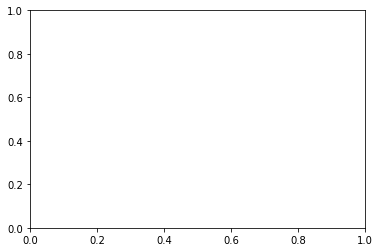

In [17]:
plt.figure()
# plt.plot(mean_degree_list, pe_list, 'yo')
# plt.plot(mean_degree_list, np.array(pe_0_list_m) +  np.array(pe_1_list_m), 'ro', alpha = 0.5)
plt.plot(mean_degree_list, np.array(pe_0_list_m) , 'g.', alpha = 0.5)
plt.plot(mean_degree_list, np.array(pe_1_list_m) , 'b.', alpha = 0.5)
# plt.plot(mean_degree_list, sim_mask_pe1, 'bp', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list_m) , 'r^')
# plt.plot(mean_degree_list, np.array(pe_0_list) + np.array(pe_1_list) , 'c^', )
plt.plot(mean_degree_list, np.array(pe_0_list) , 'm+', )
plt.plot(mean_degree_list, np.array(pe_1_list) , 'y+', )
# plt.plot(mean_degree_list, sim_mu_pe1 , 'ro', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'yo')

plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Theoratical Prob of Emergence"
plt.legend([
            "Seed is Mask         (Mask model)",
            "Seed is no Mask    (Mask model)", 
#             "Seed is no Mask    (Mask model simulation)", 
            
            "Seed is Strain-1   (Mutation model)",
            "Seed is Strain-2   (Mutation model)", ])
#             "Seed is Strain-2(Mutation model simulation)"])
plt.title(title)

np.save( "PE_0_mask_20.npy", np.array(pe_0_list_m))
np.save( "PE_1_mask_20.npy", np.array(pe_1_list_m))
np.save( "PE_0_mu_20.npy", np.array(pe_0_list))
np.save( "PE_1_mu_20.npy", np.array(pe_1_list))

In [12]:
sim_mask_path = '../../../Mask2Results/082822:20_n2000000_e100/Results/'
sim_mask_pe1 = np.load(sim_mask_path + "start-mask/Prob_Emergence.npy")
# sim_mask_pe2 = np.load("../../../Mask2Results/082317:17_n200000_e100/Results/start-nomask/")
sim_mask_pe2 = np.load(sim_mask_path + "start-nomask/Prob_Emergence.npy")



# sim_mu_pe1 = np.load("../../../MutationResults/082510:55_n50000_e100/Results/start-s1/Prob_Emergence.npy")
# sim_mu_pe2 = np.load("../../../MutationResults/082317:14_n2000000_e100/Results/start-s1/Prob_Emergence.npy")


Text(0.5, 1.0, 'Prob of Emergence for Mask Model')

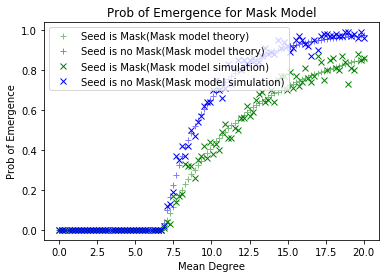

In [13]:
plt.figure()
# plt.plot(mean_degree_list, pe_list, 'yo')
# plt.plot(mean_degree_list, np.array(pe_0_list_m) +  np.array(pe_1_list_m), 'r+', alpha = 0.5)
plt.plot(mean_degree_list, np.array(pe_0_list_m) , 'g+', alpha = 0.5)
plt.plot(mean_degree_list, np.array(pe_1_list_m) , 'b+', alpha = 0.5)
# plt.plot(mean_degree_list, sim_mask_pe1, 'bp', alpha = 0.5)
plt.plot(mean_degree_list, np.array(sim_mask_pe1) , 'gx')
plt.plot(mean_degree_list, np.array(sim_mask_pe2) , 'bx')
# plt.plot(mean_degree_list, np.array(pe_0_list) + np.array(pe_1_list) , 'c^', )
# plt.plot(mean_degree_list, np.array(pe_0_list) , 'm^', )
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'y^', )
# plt.plot(mean_degree_list, sim_mu_pe1 , 'ro', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'yo')

plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Prob of Emergence for Mask Model"
plt.legend([
            "Seed is Mask(Mask model theory)",
            "Seed is no Mask(Mask model theory)", 
            "Seed is Mask(Mask model simulation)", 
    "Seed is no Mask(Mask model simulation)", 
            
            ])
#             "Seed is Strain-2(Mutation model simulation)"])
plt.title(title)

Text(0.5, 1.0, 'Prob of Emergence for Mutation Model')

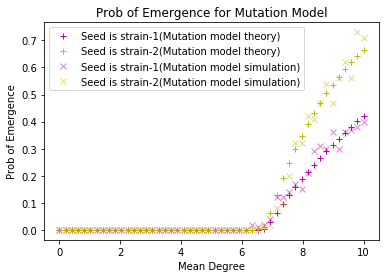

In [46]:
plt.figure()
# plt.plot(mean_degree_list, pe_list, 'yo')
# plt.plot(mean_degree_list, np.array(pe_0_list_m) +  np.array(pe_1_list_m), 'r+', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_0_list_m) , 'g+', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list_m) , 'b+', alpha = 0.5)
# plt.plot(mean_degree_list, sim_mask_pe1, 'bp', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(sim_mask_pe1) , 'bx')
# plt.plot(mean_degree_list, np.array(pe_0_list) + np.array(pe_1_list) , 'c+', )
plt.plot(mean_degree_list, np.array(pe_0_list) , 'm+', )
plt.plot(mean_degree_list, np.array(pe_1_list) , 'y+', )

plt.plot(mean_degree_list, sim_mu_pe1 , 'mx', alpha = 0.5)
plt.plot(mean_degree_list, sim_mu_pe2 , 'yx', alpha = 0.5)
# plt.plot(mean_degree_list, np.array(pe_1_list) , 'yo')

plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Prob of Emergence for Mutation Model"
plt.legend([
            "Seed is strain-1(Mutation model theory)",
            "Seed is strain-2(Mutation model theory)", 
            "Seed is strain-1(Mutation model simulation)", 
    "Seed is strain-2(Mutation model simulation)", 
            
            ])
#             "Seed is Strain-2(Mutation model simulation)"])
plt.title(title)